Summary:
1. SVM with RBF kernel was trained with 20 features selected through a chi squared test. It achieved 73.8% accuracy on the test set.
2. SVM with Linear kernel was trained with 16 features selected through RFECV. It achived 74.4% accuracy on the test set. The model also trains much faster than the one with RBF kernel. This model assigns heavy weights to the number of assists made by both teams before halftime. The number of red cards the home team gets before half time also has decent weight.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV, chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, accuracy_score
from itertools import cycle
import matplotlib.pyplot as plt

In [2]:
def plot_precision_recall_curve(n_classes, precision, recall):
    # Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange'])

    plt.figure(figsize=(7, 8))
    lines = []
    labels = []

    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall')

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0}'.format(i))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

    plt.show()

def show_classification_metrics(classifier, features, y_true, n_classes):
    prob = None
    y_pred = classifier.predict(features)
    
    try:
        prob = classifier.predict_proba(features)
    except:
        pass
    
    if prob is None:
        try:
            prob = classifier.decision_function(features)
        except:
            print("Cannot get class probability or decision function from classifier")
            return
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], prob[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], prob[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),prob.ravel())
    average_precision["micro"] = average_precision_score(y_true, prob,average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
    print()
    
    precision_micro = precision_score(y_true, y_pred, average="micro")
    precision_weighted = precision_score(y_true, y_pred, average="weighted")
    precision_macro = precision_score(y_true, y_pred, average="macro")

    recall_micro = recall_score(y_true, y_pred, average="micro")
    recall_weighted = recall_score(y_true, y_pred, average="weighted")
    recall_macro = recall_score(y_true, y_pred, average="macro")

    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    print("Accuracy score: {:.3f}".format(accuracy_score(y_true, y_pred)))
    print()
    
    print("Precision score (micro): {:.3f}".format(precision_micro))
    print("Recall score (micro): {:.3f}".format(recall_micro))
    print("F1 score (micro): {:.3f}".format(f1_micro))
    print()
    print("Precision score (weighted): {:.3f}".format(precision_weighted))
    print("Recall score (weighted): {:.3f}".format(recall_weighted))
    print("F1 score (weighted): {:.3f}".format(f1_weighted))
    print()
    print("Precision score (macro): {:.3f}".format(precision_macro))
    print("Recall score (macro): {:.3f}".format(recall_macro))
    print("F1 score (macro): {:.3f}".format(f1_macro))
    
    plot_precision_recall_curve(n_classes, precision, recall)

In [3]:
train_df = pd.read_csv("Data/formated.csv")
test_df = pd.read_csv("Data/formatedTesting.csv")

train_df.columns = [col.strip() for col in train_df.columns]
test_df.columns = [col.strip() for col in test_df.columns]

In [4]:
train_df.columns

Index(['events', 'shots made', 'is goal', 'assist count', 'fast break', 'e1',
       'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12',
       'e13', 'e14', 'e15', 's1', 's2', 's3', 's4', 'sp1', 'sp2', 'sp3', 'sp4',
       'sp5', 'sp6', 'sp7', 'sp8', 'sp9', 'sp10', 'sp11', 'sp12', 'sp13',
       'events 2', 'shots made 2', 'is goal 2', 'assist count 2',
       'fast break 2', 'e1.1', 'e2.1', 'e3.1', 'e4.1', 'e5.1', 'e6.1', 'e7.1',
       'e8.1', 'e9.1', 'e10.1', 'e11.1', 'e12.1', 'e13.1', 'e14.1', 'e15.1',
       's1.1', 's2.1', 's3.1', 's4.1', 'sp1.1', 'sp2.1', 'sp3.1', 'sp4.1',
       'sp5.1', 'sp6.1', 'sp7.1', 'sp8.1', 'sp9.1', 'sp10.1', 'sp11.1',
       'sp12.1', 'sp13.1', 'target Feature'],
      dtype='object')

There's some imbalance between the target features as seen by the charts below. The number of games where the result is draw is significantly less than the other types

Text(0.5,1,'Target feature distribution in training set')

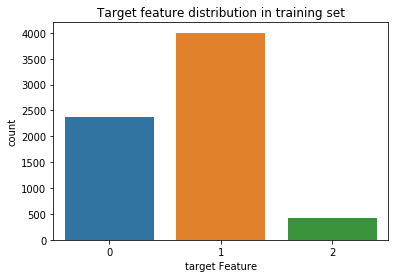

In [103]:
sns.countplot(train_df["target Feature"])
plt.title("Target feature distribution in training set")

Text(0.5,1,'Target feature distribution in test set')

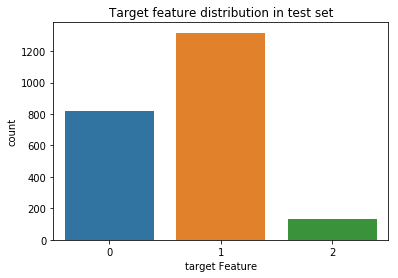

In [104]:
sns.countplot(test_df["target Feature"])
plt.title("Target feature distribution in test set")

## Feature selection and hyperparameter tuning for SVM with RBF kernel

In [5]:
# Split the dataframe into features and labels arrays
train_features_array = train_df.iloc[:, :-1].values
train_labels_array = train_df.loc[:, "target Feature"].values
train_labels_binarized = label_binarize(train_labels_array, classes=[0,1,2])

test_features_array = test_df.iloc[:, :-1].values
test_labels_array = test_df.loc[:, "target Feature"].values
test_labels_binarized = label_binarize(test_labels_array, classes=[0,1,2])

In [124]:
# Feature selection using chi2 test
select_k_best = SelectKBest(chi2, k="all")
select_k_best.fit(train_features_array, train_labels_array)

feature_scores = pd.DataFrame({"feature": train_df.columns[:-1], "chi2_score": select_k_best.scores_,
                              "p_value": select_k_best.pvalues_})

print("Number of features where p_value < 0.05: {}\n".format(feature_scores[feature_scores["p_value"] < 0.05].shape[0]))
print("Top 10 features according to chi squared score:")
print(feature_scores[feature_scores["p_value"] < 0.05].sort_values("chi2_score", ascending=False)[:10])

Number of features where p_value < 0.05: 57

Top 10 features according to chi squared score:
           feature   chi2_score        p_value
40  assist count 2  1798.223516   0.000000e+00
38    shots made 2  1797.710441   0.000000e+00
3     assist count  1797.378472   0.000000e+00
42            e1.1  1766.470087   0.000000e+00
1       shots made  1753.166242   0.000000e+00
5               e1  1741.715658   0.000000e+00
57            s1.1  1664.908265   0.000000e+00
20              s1  1531.331278   0.000000e+00
37        events 2   758.872534  1.632762e-165
0           events   719.802457  4.976024e-157


In [ ]:
# Define scorer for grid search
accuracy_scorer = make_scorer(accuracy_score)

# Run grid search to determine the best number of features and values for hyperparameters
pipe = Pipeline([
    # the reduce_dim stage is populated by the param_grid
    ('reduce_dim', None),
    ('normalize', MinMaxScaler((0,1))),
    ('classify', SVC(kernel="rbf"))
])

N_FEATURES_OPTIONS = [10, 20, 30, 40]
C_OPTIONS = [1, 5, 10, 50, 100]
GAMMA_OPTIONS = [0.01, 0.05, 0.001, 0.005]
param_grid = [
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS,
        'classify__gamma': GAMMA_OPTIONS
    },
]
reducer_labels = ['KBest(chi2)']

grid = GridSearchCV(pipe, cv=5, n_jobs=2, param_grid=param_grid)
grid.fit(train_features_array, train_labels_array)

In [113]:
n_features = grid.best_params_["reduce_dim__k"]
best_C = grid.best_params_["classify__C"]
best_gamma = grid.best_params_["classify__gamma"]

print("Cross validation best_accuracy score: {:.3f}".format(grid.best_score_))
print("Best C: {}".format(best_C))
print("Best gamma: {}".format(best_gamma))
print("Best number of features: {}".format(n_features))
print("Features selected:")
print(feature_scores[feature_scores["p_value"] < 0.05].sort_values("chi2_score", ascending=False)[:n_features])

Cross validation best_accuracy score: 0.753
Best C: 100
Best gamma: 0.05
Best number of features: 20
Features selected:
           feature   chi2_score        p_value
40  assist count 2  1798.223516   0.000000e+00
38    shots made 2  1797.710441   0.000000e+00
3     assist count  1797.378472   0.000000e+00
42            e1.1  1766.470087   0.000000e+00
1       shots made  1753.166242   0.000000e+00
5               e1  1741.715658   0.000000e+00
57            s1.1  1664.908265   0.000000e+00
20              s1  1531.331278   0.000000e+00
37        events 2   758.872534  1.632762e-165
0           events   719.802457  4.976024e-157
62           sp2.1   645.331561  7.379586e-141
6               e2   577.401348  4.158056e-126
25             sp2   522.465122  3.532973e-114
43            e2.1   439.590733   3.500138e-96
31             sp8   279.897254   1.663733e-61
69           sp9.1   239.168420   1.162084e-52
28             sp5   222.817247   4.129044e-49
68           sp8.1   198.831519   

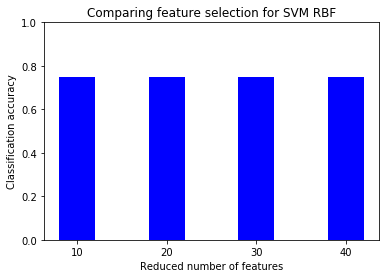

In [114]:
# Taken from: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py
mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = mean_scores.reshape(len(C_OPTIONS), len(GAMMA_OPTIONS), len(N_FEATURES_OPTIONS))
mean_scores = mean_scores.max(axis=(0,1))

bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature selection for SVM RBF")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets, N_FEATURES_OPTIONS)
plt.ylabel('Classification accuracy')
plt.ylim((0, 1))

plt.show()

In [123]:
# Train the SVM on the entire training set using the parameters determined by grid search
svm_pipe = Pipeline([
    ('reduce_dim', SelectKBest(chi2, k=n_features)),
    ('normalize', MinMaxScaler((0,1))),
    ('classify', SVC(kernel="rbf", C=best_C, gamma=best_gamma))
])

svm_pipe.fit(train_features_array, train_labels_array)

print("Accuracy score on test set: {:.3f}".format(svm_pipe.score(test_features_array, test_labels_array)))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy score on test set: 0.738


## Feature selection and hyperparameter tuning for SVM with Linear kernel

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Optimal number of features : 16


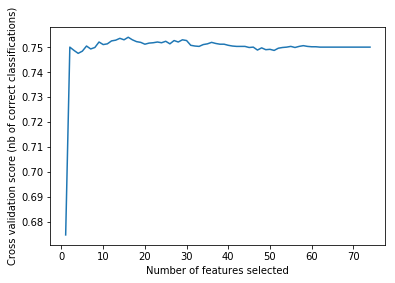

In [6]:
# Taken from: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
normalizer = MinMaxScaler((0, 1))
normalizer.fit(train_features_array)

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(normalizer.transform(train_features_array), train_labels_array)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [33]:
rfe_ranking = pd.DataFrame({"features": train_df.columns[:-1], "rfecv_rank": rfecv.ranking_})
print("Top 16 features according to RFECV")
print(rfe_ranking.sort_values("rfecv_rank")[:16])

Top 16 features according to RFECV
          features  rfecv_rank
0           events           1
57            s1.1           1
47            e6.1           1
22              s3           1
38    shots made 2           1
39       is goal 2           1
40  assist count 2           1
58            s2.1           1
43            e2.1           1
10              e6           1
31             sp8           1
1       shots made           1
8               e4           1
6               e2           1
2          is goal           1
3     assist count           1


In [11]:
selected_features = rfecv.transform(normalizer.transform(train_features_array))

In [13]:
# Define scorer for grid search
accuracy_scorer = make_scorer(accuracy_score)

# Find the best value of C for SVM with Linear kernel
param_grid = {
        "C": [1, 2, 3, 4, 5, 10, 50, 100]
    }

grid = GridSearchCV(SVC(kernel="linear"), cv=5, n_jobs=2, param_grid=param_grid)
grid.fit(selected_features, train_labels_array)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'C': [1, 2, 3, 4, 5, 10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
best_C = grid.best_params_["C"]

print("Cross validation best_accuracy score: {:.3f}".format(grid.best_score_))
print("Best C: {}".format(best_C))

Cross validation best_accuracy score: 0.755
Best C: 10


In [15]:
# Train the SVM on the entire training set using the parameters determined by grid search
linear_svm = SVC(kernel="linear", C=best_C)
linear_svm.fit(selected_features, train_labels_array)

selected_test_features = rfecv.transform(normalizer.transform(test_features_array))

print("Accuracy score on test set: {:.3f}".format(linear_svm.score(selected_test_features, test_labels_array)))

Accuracy score on test set: 0.744


In [30]:
feature_coefs_class_0 = rfe_ranking.sort_values("rfecv_rank")[:rfecv.n_features_]
feature_coefs_class_0 = feature_coefs_class_0.sort_index()
feature_coefs_class_0["coef"] = linear_svm.coef_[0]
feature_coefs_class_0["abs_coef"] = feature_coefs_class_0["coef"].abs()

In [32]:
feature_coefs_class_0.sort_values("abs_coef", ascending=False)

,features,rfecv_rank,coef,abs_coef
3,assist count,1,-5.874114,5.874114
40,assist count 2,1,5.628368,5.628368
10,e6,1,1.356608,1.356608
1,shots made,1,-1.277360,1.277360
39,is goal 2,1,-1.069755,1.069755
6,e2,1,-0.980966,0.980966
38,shots made 2,1,0.892225,0.892225
8,e4,1,0.867715,0.867715
47,e6.1,1,-0.850201,0.850201
57,s1.1,1,0.796329,0.796329


Linear SVM assigns very high weights to assist counts of both teams. The number of red cards received by team 1 prior to half time also has decent weight.